In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talib 
pd.options.mode.chained_assignment = None

# Dickey-Fuller test
#from statsmodels.tsa.stattools import adfuller
#from scipy.signal import hilbert  区别 from statsmodels.tsa.stattools import
from pyhht.utils import inst_freq
from pyhht import EMD

from scipy.signal import argrelextrema
import scipy.interpolate as spi

import tushare as ts
pro = ts.pro_api('9293b9b01414a95f89aa75f884c907fdc2cd24f41c8ea3de863eaa26')


In [12]:
#复权个股日线
sd = '20191215'
ed = '20210806'

#tc = '399300.SZ'
tc = '600438.SH'
#tc = '002493.SZ'
#tc = '600036.SH'

#['600438.SS','601168.SS','600765.SS']
#'601012.SS', '600438.SS','300014.SZ','002460.SZ','600745.SS','603986.SS','603005.SS'
#,'603501.SS','601168.SS','600309.SS','002493.SZ','600176.SS','600426.SS','600989.SS','600893.SS'
#,'600760.SS','000733.SZ','600765.SS','002373.SZ','600033.SS','600036.SS'
data = ts.pro_bar(api=pro, ts_code=tc, adj='qfq', start_date=sd, end_date=ed,freq='d')  ##个股日线freq='d' 周线freq='w'

#data = pro.index_daily(ts_code=tc, adj='qfq', start_date=sd, end_date=ed)     ##指数日线
#data = pro.index_weekly(ts_code=tc, adj='qfq', start_date='20190101', end_date='20210526')    ##指数周线

data = data[::-1].reset_index(drop=True) #初始索引倒置
data['trade_date'] = pd.to_datetime(data['trade_date'],format='%Y%m%d')
data.set_index('trade_date', inplace=True)

#df = data[-144:]
 

144


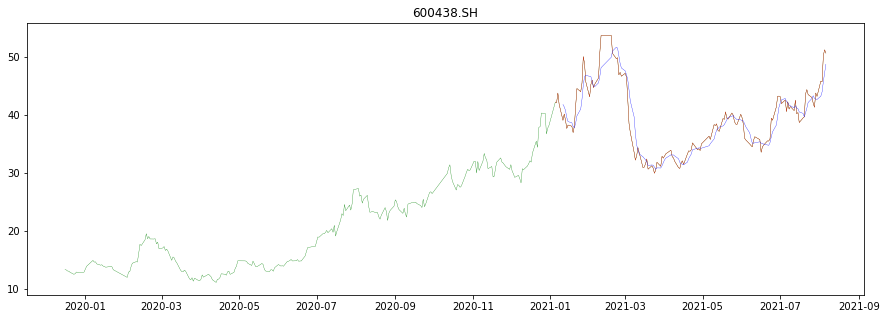

In [13]:
df = data.tail(144)
print(len(df))
#df['f_close'] = forcast(df['close'],21)
#df['f_close'] = df['close'].ewm(span=3).mean()
df['w_close']=df['close'].rolling(5).mean()

plt.figure(figsize=(15, 5))
#plt.figure(figsize=(10,6), dpi=256)
plt.title(str(tc))

plt.plot(data['close'], color="Green", linewidth=0.3, linestyle="-")
plt.plot(df['close'], color="red", linewidth=0.3, linestyle="-")
plt.plot(df['w_close'], color = "blue",  linewidth=0.3, linestyle="-")

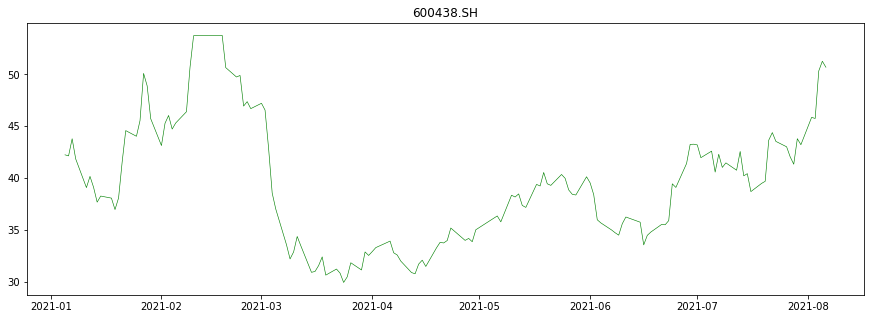

In [14]:
# convert strings to dates
ftseinfo = df
ftseinfo['Date'] = ftseinfo.index
#print(ftseinfo['trade_date'])
ftseinfo['Date'] = pd.to_datetime(ftseinfo['Date'], format="%d-%b-%Y" )

# convenience variable for plots
date_axis = ftseinfo['Date']

# The date entries are not evenly spaced, so calculate number of days from first date for each
first_date = date_axis[0]
deltas = ftseinfo['Date'] - first_date

def getdays(delta):
    return delta.days

ftseinfo['deltadays'] = deltas.apply(getdays)

# convenience variable for days
days = ftseinfo['deltadays']

plt.figure(figsize=(15, 5))
#plt.figure(figsize=(10,6), dpi=256)
plt.title(str(tc))

plt.plot(ftseinfo['close'], color="green", linewidth=0.6, linestyle="-")



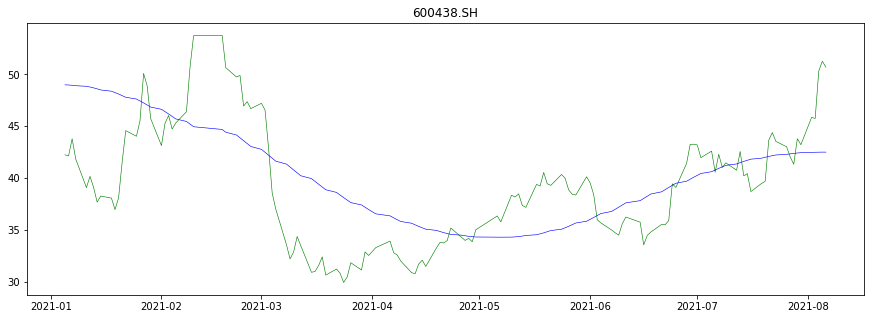

In [15]:
def decompose( x, y ):
    decomposer = EMD( y )
    imfs = decomposer.decompose()
    return imfs
    
def emd_analysis( days, data_values ):
    
    # decompose time series into intrinsic mode functions
    imfs = decompose(days, data_values)
    #print(imfs)
    # extract the residue (overall trend)
    imf_residue = imfs[len(imfs)-1]
    return (imfs, imf_residue )

    
# Do the decomposition on the closing price time series
( imfs, imf_residue ) = emd_analysis( days,ftseinfo['close'])
ftseinfo['imf_residue']=imf_residue

plt.figure(figsize=(15, 5))
#plt.figure(figsize=(10,6), dpi=256)
plt.title(str(tc))
plt.plot(ftseinfo['close'], color="green", linewidth=0.6, linestyle="-")
plt.plot(ftseinfo['imf_residue'], color="blue", linewidth=0.6, linestyle="-")
#plt.plot(ftseinfo['envelope'] , color="red", linewidth=0.6, linestyle="-")


No handles with labels found to put in legend.


第一次去除趋势


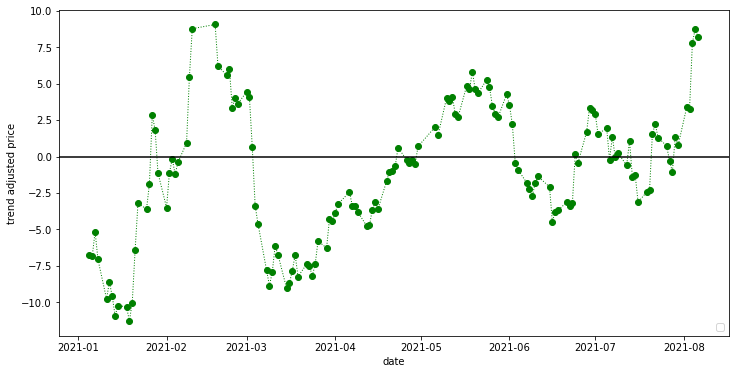

In [16]:
ftseinfo['trend_adjusted_1'] = ftseinfo['close'] - imf_residue

print('第一次去除趋势')

# Let's look at adjusted prices
fig = plt.figure(figsize=(12,6))
sp1 = fig.add_subplot(111)
plt.xlabel('date')
plt.ylabel('trend adjusted price')

sp1.plot_date( x=date_axis, y=ftseinfo['trend_adjusted_1'],linewidth=1, linestyle= 'dotted', color='green' )
plt.axhline(0, color='black')

plt.legend(loc='lower right')
plt.show()



No handles with labels found to put in legend.


4


Text(0, 0.5, 'Amplitude')

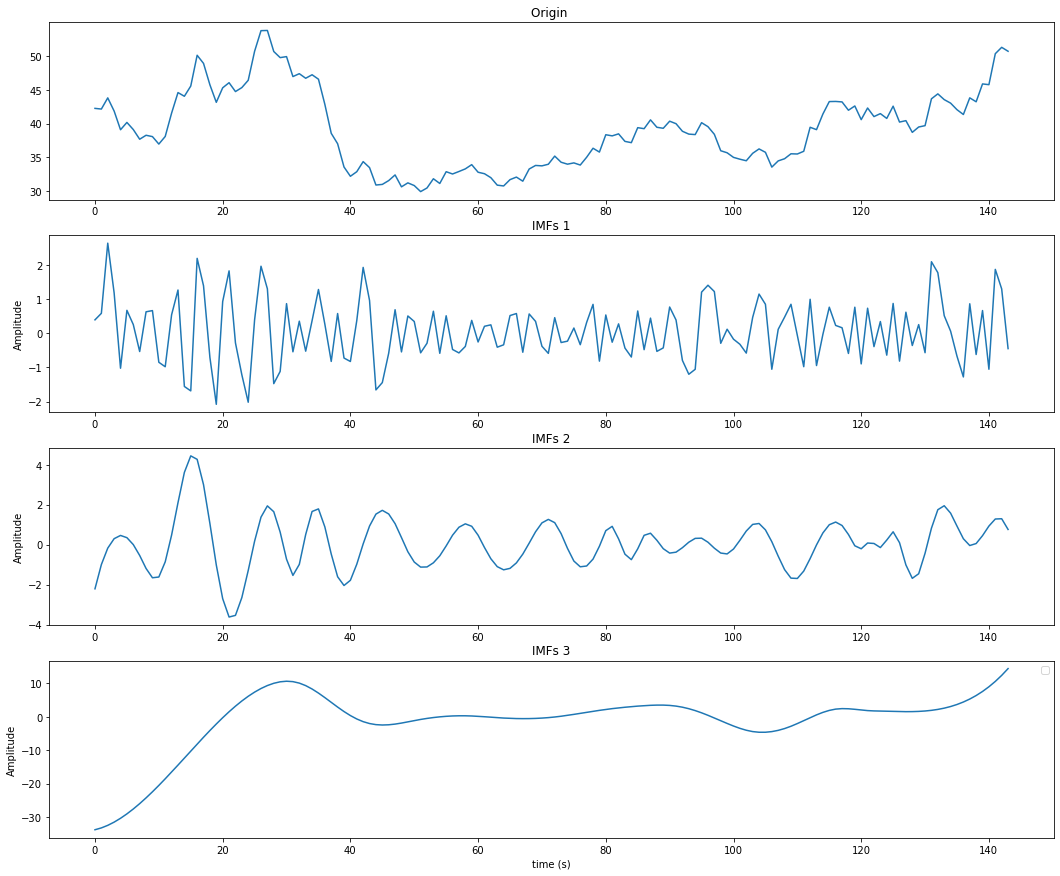

In [17]:


def sifting(e_data):
    index = list(range(len(e_data)))

    max_peaks = list(argrelextrema(e_data, np.greater)[0])
    min_peaks = list(argrelextrema(e_data, np.less)[0])

    ipo3_max = spi.splrep(max_peaks, e_data[max_peaks],k=3) #样本点导入，生成参数
    iy3_max = spi.splev(index, ipo3_max) #根据观测点和样条参数，生成插值

    ipo3_min = spi.splrep(min_peaks, e_data[min_peaks],k=3) #样本点导入，生成参数
    iy3_min = spi.splev(index, ipo3_min) #根据观测点和样条参数，生成插值

    iy3_mean = (iy3_max+iy3_min)/2
    #print('5')
    return e_data-iy3_mean
    
def hasPeaks(e_data):
    max_peaks = list(argrelextrema(e_data, np.greater)[0])
    min_peaks = list(argrelextrema(e_data, np.less)[0])
    #print('4')
    if len(max_peaks)>3 and len(min_peaks)>3:
        return True
    else:
        return False


# 判断IMFs
def isIMFs(e_data):
    max_peaks = list(argrelextrema(e_data, np.greater)[0])
    min_peaks = list(argrelextrema(e_data, np.less)[0])
    #print('3')
    if min(e_data[max_peaks]) < 0 or max(e_data[min_peaks])>0:
        return False
    else:
        return True


def getIMFs(e_data):
    i = 0
    while(not isIMFs(e_data)):
        #print('2')
        e_data = sifting(e_data)
        i += 1
        if i>10 :
            break
    return e_data


# EMD函数
def EMD(e_data):
    IMFs = []
    while hasPeaks(e_data):
        #print('1')
        data_imf = getIMFs(e_data)
        e_data = e_data-data_imf
        IMFs.append(data_imf)
    return IMFs

# 绘制对比图
e_data = np.array(df['close'])
IMFs = EMD(e_data)
n = len(IMFs)+1
print(n)
# 原始信号
plt.figure(figsize = (18,15))
plt.subplot(n, 1, 1)
plt.plot(e_data, label='Origin')
plt.title("Origin ")

# 若干条IMFs曲线
for i in range(0,len(IMFs)):
    plt.subplot(n, 1, i+2)
    plt.plot(IMFs[i])
    plt.ylabel('Amplitude')
    plt.title("IMFs "+str(i+1))

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Amplitude')

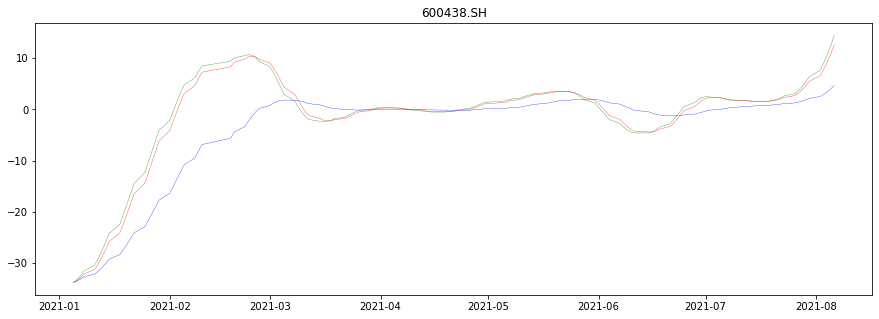

In [18]:
 #------------------------------EMA多头判断------------------------------------------------------------------
dhf = df
#dhf['close'] = ftseinfo['trend_adjusted_5']
dhf['close'] = IMFs[2]
dhf['w_close']=dhf['close'].rolling(5).mean()

dhf['ema5']  = dhf['close'].ewm(span=3).mean()
dhf['ema10']  = dhf['close'].ewm(span=10).mean()
dhf['ema20']  = dhf['close'].ewm(span=30).mean()
dhf['ema60']  = dhf['close'].ewm(span=60).mean()

#---------------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.title(str(tc))

plt.plot(df['close'], color="green", linewidth=0.3, linestyle="-")
plt.plot(df['ema5'], color="red", linewidth=0.3, linestyle="-")
plt.plot(df['ema20'], color = "blue",  linewidth=0.3, linestyle="-")

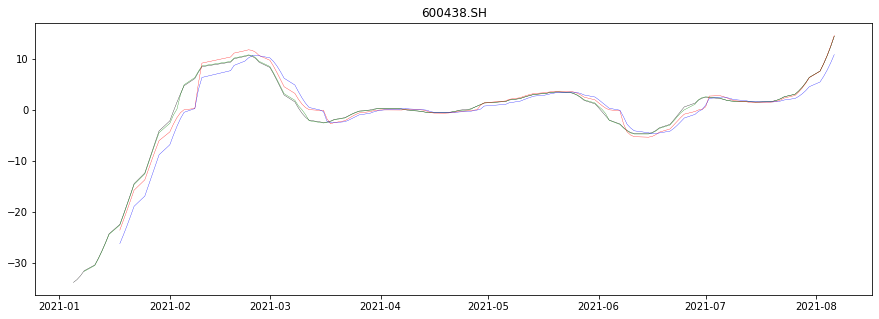

In [19]:
def ssa(series, windowLen , pcn  ):
    seriesLen = len(series)
    K = seriesLen - windowLen + 1
    X = np.zeros((windowLen, K))
    for i in range(K):
        X[:, i] = series[i:i + windowLen]
    
    U, sigma, VT = np.linalg.svd(X, full_matrices=False)

    for i in range(VT.shape[0]):
        VT[i, :] *= sigma[i]
    A = VT

    rec = np.zeros((windowLen, seriesLen))
    for i in range(windowLen):
        for j in range(windowLen-1):
            for m in range(j+1):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= (j+1)
        for j in range(windowLen-1, seriesLen - windowLen + 1):
            for m in range(windowLen):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= windowLen
        for j in range(seriesLen - windowLen + 1, seriesLen):
            for m in range(j-seriesLen+windowLen, windowLen):
                rec[i, j] += A[i, j - m] * U[m, i]
            rec[i, j] /= (seriesLen - j)
    
    result = np.sum(rec[:pcn], axis=0)
    return result[-1]
    #return result
#--------------------------------------------------------------------------------------------------------  
pcn = 1
fwl = 2
swl = 5
dwl = 3
#---------------------------------三SSA-------------------------------------------------
dhf['f_ssa'] = dhf['close'].rolling(2*fwl).apply(ssa,args = (fwl,pcn),raw = True) 
dhf['s_ssa'] = dhf['close'].rolling(2*swl).apply(ssa,args = (swl,pcn),raw = True) 
dhf['w_ssa'] = dhf['w_close'].rolling(2*dwl).apply(ssa,args = (dwl,pcn),raw = True) 
#---------------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
plt.title(str(tc))

plt.plot(dhf['close'], color="black", linewidth=0.3, linestyle="-")
plt.plot(dhf['f_ssa'], color="green", linewidth=0.3, linestyle="-")
plt.plot(dhf['s_ssa'], color="red", linewidth=0.3, linestyle="-")
plt.plot(dhf['w_ssa'], color = "blue",  linewidth=0.3, linestyle="-")

策略收益率：1.5415673268710277
基准收益率：0.22445162101391714


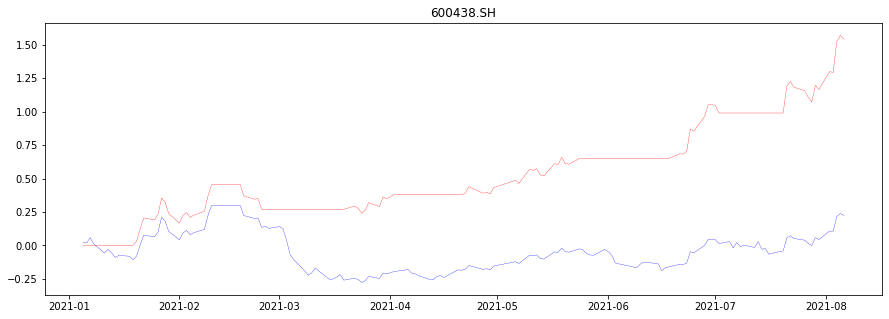

In [20]:
#---------------------------------买卖点策略-------------------------------------------------
#DataFrame.diff(periods=1, axis=0) ; periods：移动的幅度，int类型，默认值为1;
# axis：移动的方向，{0 or ‘index’, 1 or ‘columns’}，
# 如果为0或者’index’，则上下移动，如果为1或者’columns’，则左右移动。
dhf['dfe'] = dhf['f_ssa']-dhf['ema5']
dhf['dtf'] = dhf['f_ssa']-dhf['f_ssa'].shift(1) 
dhf['dts'] = dhf['s_ssa']-dhf['s_ssa'].shift(1) 
dhf['dtw'] = dhf['w_ssa']-dhf['w_ssa'].shift(1) 

#df['ddx'] =  (df['dtf']>0.0000)  & (df['dts']>0) & (df['dtw']>0.0000)  
dhf['ddx'] =  (dhf['dtf']>0.0000)  & (dhf['dtw']>0) & (dhf['dfe']>0.0000) 
#print(df['ddx'])

#---------------------------------回测收益-------------------------------------------------
dhf['res'] = np.select([dhf['ddx'] > 0],[dhf['close']],default = np.nan)  #获取快慢SSA >0的时序
dhf['attack'] = np.select([dhf['ddx'] > 0],[1],default = 0)#获取“双SSA斜率差 >0策略”的时序的触发信号

bs = np.array(dhf['attack'])

#print("买卖信号A:"+str(bs[-1]))

dhf['buy'] = dhf['attack'].shift(1) #下移一行买入信号
bs2 = np.array(dhf['buy'])
#print("买卖信号B:"+str(bs2[-1]))
#print(np.array(df['buy']))

dhf['base_profit'] = 1+0.01*dhf['pct_chg'].fillna(0) #计算基准每日收益
dhf['prod_base_profit'] = dhf['base_profit'].cumprod()-1 #计算基准每日收益累乘
dhf['profit'] = np.select([dhf['buy'] == 1],[dhf['base_profit']],default = 1) #计算策略每日收益
dhf['profit'] = dhf['profit'].fillna(0)
#print(np.array(data['profit']))

dhf['prod_profit'] = dhf['profit'].cumprod()-1#计算策略每日收益累乘
dhf['max_profit'] = dhf['prod_profit'].max()

plt.figure(figsize=(15, 5))
plt.title(str(tc))

plt.plot(dhf['prod_profit'], color="red", linewidth=0.3, linestyle="-")
plt.plot(dhf['prod_base_profit'], color = "blue",  linewidth=0.3, linestyle="-")

print("策略收益率："+str(np.array(dhf['prod_profit'])[-1])) 
print("基准收益率："+str(np.array(dhf['prod_base_profit'])[-1]))